In [1]:
import pandas as pd
df=pd.read_csv('fpl_def_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27190 entries, 0 to 27189
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   season                      27190 non-null  object 
 1   gameweek                    27190 non-null  int64  
 2   name                        27190 non-null  object 
 3   position                    27190 non-null  object 
 4   team                        27190 non-null  object 
 5   xP                          27190 non-null  float64
 6   assists                     27190 non-null  int64  
 7   bonus                       27190 non-null  int64  
 8   bps                         27190 non-null  int64  
 9   clean_sheets                27190 non-null  int64  
 10  creativity                  27190 non-null  float64
 11  element                     27190 non-null  int64  
 12  fixture                     27190 non-null  int64  
 13  goals_conceded              271

In [1]:
import pandas as pd

# Load data
def_df = pd.read_csv("fpl_def_data.csv")

# Sort by player and gameweek for rolling features
def_df = def_df.sort_values(by=['element', 'gameweek']).reset_index(drop=True)

# Rolling metrics (3-match rolling window)
rolling_cols = ['total_points', 'minutes', 'clean_sheets', 'goals_scored', 'assists']
for col in rolling_cols:
    def_df[f'{col}_last_3'] = def_df.groupby('element')[col].transform(lambda x: x.shift(1).rolling(window=3).mean())

# Clean sheet ratio: clean_sheets / starts
def_df['clean_sheet_ratio'] = def_df['clean_sheets'] / (def_df['starts'] + 1e-5)

# Goal contribution per 90 = (goals + assists) / minutes * 90
def_df['goal_contribution_ratio'] = (def_df['goals_scored'] + def_df['assists']) / (def_df['minutes'] + 1e-5) * 90

# Expected contribution = xG + xA
def_df['expected_contribution'] = def_df['expected_goals'] + def_df['expected_assists']

# Defensive impact (scaled): influence + bps + ict_index
def_df['defensive_influence'] = def_df[['influence', 'bps', 'ict_index']].sum(axis=1)

# Attacking threat score: threat + creativity
def_df['attacking_threat'] = def_df['threat'] + def_df['creativity']

# Drop rows with NaNs from rolling features
def_df = def_df.dropna()

# Save engineered data
def_df.to_csv("fpl_def_data.csv", index=False)

print("✅ Feature engineering for DEF complete. New shape:", def_df.shape)


✅ Feature engineering for DEF complete. New shape: (25473, 53)


In [2]:
def_df.isna().sum()

season                        0
gameweek                      0
name                          0
position                      0
team                          0
xP                            0
assists                       0
bonus                         0
bps                           0
clean_sheets                  0
creativity                    0
element                       0
fixture                       0
goals_conceded                0
goals_scored                  0
ict_index                     0
influence                     0
kickoff_time                  0
minutes                       0
opponent_team                 0
own_goals                     0
penalties_missed              0
penalties_saved               0
red_cards                     0
round                         0
saves                         0
selected                      0
team_a_score                  0
team_h_score                  0
threat                        0
total_points                  0
transfer

C:\Users\shaunak\AppData\Local\Temp\ipykernel_22476\2059200224.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\shaunak\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


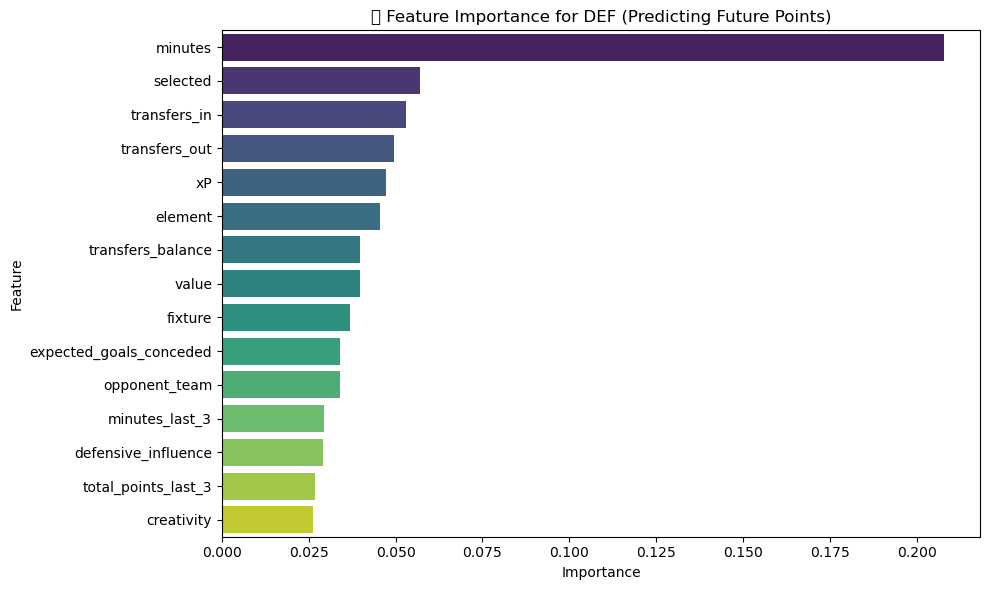

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Load engineered DEF dataset
def_df = pd.read_csv("fpl_def_feature_engineered.csv")

# 🔹 Drop non-numeric and unneeded columns
drop_cols = ['season', 'name', 'position', 'team', 'kickoff_time']
def_df = def_df.drop(columns=drop_cols)

# 🔹 Drop NaNs (from rolling features)
def_df = def_df.dropna()

# 🔹 Split features and target
X = def_df.drop(columns=['future_points'])
y = def_df['future_points']

# 🔹 Time-aware split: simulate season progression
X_train = X[X['gameweek'] <= 30]
X_test = X[X['gameweek'] > 30]
y_train = y[X['gameweek'] <= 30]
y_test = y[X['gameweek'] > 30]

# Optional: drop 'gameweek' now (not needed as feature)
X_train = X_train.drop(columns=['gameweek'])
X_test = X_test.drop(columns=['gameweek'])

# 🔹 Fit HistGradientBoostingRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 🔹 Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# 🔹 Create DataFrame of importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# 🔹 Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('📊 Feature Importance for DEF (Predicting Future Points)')
plt.tight_layout()
plt.show()


In [7]:
def_df.corr(numeric_only=True)['future_points'].sort_values(ascending=False)

future_points                 1.000000
minutes                       0.450682
defensive_influence           0.401933
starts                        0.393379
bps                           0.381970
influence                     0.378894
ict_index                     0.374207
xP                            0.362570
total_points                  0.314057
minutes_last_3                0.311200
attacking_threat              0.302790
expected_goals_conceded       0.300935
goals_conceded                0.277780
value                         0.273498
creativity                    0.261334
total_points_last_3           0.253685
selected                      0.248720
threat                        0.228114
expected_contribution         0.226655
expected_goal_involvements    0.226102
transfers_in                  0.208969
clean_sheets                  0.208852
expected_assists              0.196669
clean_sheets_last_3           0.186758
bonus                         0.151860
expected_goals           

In [3]:
def_df.drop(['fixture','element','round','team_a_score','team_h_score','penalties_missed','penalties_saved','saves','red_cards','was_home','opponent_team','own_goals','goal_contribution_ratio'],axis=1,inplace=True)

In [4]:
def_df.columns

Index(['season', 'gameweek', 'name', 'position', 'team', 'xP', 'assists',
       'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'selected', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'yellow_cards',
       'expected_assists', 'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'starts', 'future_points',
       'total_points_last_3', 'minutes_last_3', 'clean_sheets_last_3',
       'goals_scored_last_3', 'assists_last_3', 'clean_sheet_ratio',
       'expected_contribution', 'defensive_influence', 'attacking_threat'],
      dtype='object')

In [5]:
def_df.to_csv('fpl_def_data.csv',index=False)

# Model

In [1]:
import pandas as pd
df=pd.read_csv('fpl_def_data.csv')

In [2]:
df.isna().sum()

season                        0
gameweek                      0
name                          0
position                      0
team                          0
xP                            0
assists                       0
bonus                         0
bps                           0
clean_sheets                  0
creativity                    0
goals_conceded                0
goals_scored                  0
ict_index                     0
influence                     0
kickoff_time                  0
minutes                       0
selected                      0
threat                        0
total_points                  0
transfers_balance             0
transfers_in                  0
transfers_out                 0
value                         0
yellow_cards                  0
expected_assists              0
expected_goal_involvements    0
expected_goals                0
expected_goals_conceded       0
starts                        0
future_points                 0
total_po

In [9]:
df.corr(numeric_only=True)['future_points'].sort_values(ascending=False)

future_points                 1.000000
minutes                       0.450682
defensive_influence           0.401933
starts                        0.393379
bps                           0.381970
influence                     0.378894
ict_index                     0.374207
xP                            0.362570
total_points                  0.314057
minutes_last_3                0.311200
attacking_threat              0.302790
expected_goals_conceded       0.300935
goals_conceded                0.277780
value                         0.273498
creativity                    0.261334
total_points_last_3           0.253685
selected                      0.248720
threat                        0.228114
expected_contribution         0.226655
expected_goal_involvements    0.226102
transfers_in                  0.208969
clean_sheets                  0.208852
expected_assists              0.196669
clean_sheets_last_3           0.186758
bonus                         0.151860
expected_goals           

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# 🔹 Drop non-model-useful columns
df = df.drop(columns=['season', 'name', 'position', 'team', 'kickoff_time','yellow_cards','assists','assists_last_3','transfers_out','goals_scored','transfers_balance','goals_scored_last_3','clean_sheet_ratio'],axis=1)

# 🔹 Drop NaNs due to rolling features
df = df.dropna()

# 🔹 Sort by time (so future rows don't leak into training)
df = df.sort_values(by=['gameweek']).reset_index(drop=True)

# ✅ Time-based split: train on GWs 1–30, test on GWs 31–38
train_df = df[df['gameweek'] <= 30]
test_df  = df[df['gameweek'] > 30]

# 🔹 Split into features and target
X_train = train_df.drop(columns=['future_points'])
y_train = train_df['future_points']

X_test = test_df.drop(columns=['future_points'])
y_test = test_df['future_points']


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "HistGradient":HistGradientBoostingRegressor(min_samples_leaf= 50, max_leaf_nodes= 15, max_iter= 150, max_depth= 3, learning_rate= 0.1, l2_regularization= 0.1)
}

# ===============================
# Train & Evaluate
# ===============================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "R²": round(r2, 4)
    })

# ===============================
# Show Results
# ===============================
results_df = pd.DataFrame(results).sort_values(by="MAE")
print("📊 Model Performance Comparison:")
print(results_df.to_string(index=False))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 26
[LightGBM] [Info] Start training from score 1.054963
📊 Model Performance Comparison:
            Model    MAE    MSE     R²
         LightGBM 0.9939 3.8399 0.2142
     HistGradient 0.9974 3.7592 0.2307
         CatBoost 1.0057 3.9065 0.2005
          XGBoost 1.0151 3.9034 0.2012
Linear Regression 1.0610 3.8043 0.2215
    Random Forest 1.1178 4.0278 0.1757


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# 🔹 Drop non-model-useful columns
df = df.drop(columns=['season', 'name', 'position', 'team', 'kickoff_time','yellow_cards','assists','assists_last_3',
                      'goals_scored','goals_scored_last_3',
                     'expected_assists','bonus','clean_sheets_last_3'],axis=1)

# 🔹 Drop NaNs due to rolling features
df = df.dropna()

# 🔹 Sort by time (so future rows don't leak into training)
df = df.sort_values(by=['gameweek']).reset_index(drop=True)

# ✅ Time-based split: train on GWs 1–30, test on GWs 31–38
train_df = df[df['gameweek'] <= 30]
test_df  = df[df['gameweek'] > 30]

# 🔹 Split into features and target
X_train = train_df.drop(columns=['future_points'])
y_train = train_df['future_points']

X_test = test_df.drop(columns=['future_points'])
y_test = test_df['future_points']


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "HistGradient":HistGradientBoostingRegressor(min_samples_leaf= 50, max_leaf_nodes= 15, max_iter= 150, max_depth= 3, learning_rate= 0.1, l2_regularization= 0.1)
}

# ===============================
# Train & Evaluate
# ===============================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "R²": round(r2, 4)
    })

# ===============================
# Show Results
# ===============================
results_df = pd.DataFrame(results).sort_values(by="MAE")
print("📊 Model Performance Comparison:")
print(results_df.to_string(index=False))

KeyError: "['season', 'name', 'position', 'team', 'kickoff_time', 'yellow_cards', 'assists', 'assists_last_3', 'transfers_out', 'goals_scored', 'transfers_balance', 'goals_scored_last_3', 'clean_sheet_ratio'] not found in axis"

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
df=pd.read_csv('fpl_def_data.csv')

# 🔹 Drop non-model-useful columns
df = df.drop(columns=['season', 'name', 'position', 'team', 'kickoff_time','yellow_cards','assists','assists_last_3',
                      'goals_scored','goals_scored_last_3',
                     'expected_assists','bonus','clean_sheets_last_3'],axis=1)

# 🔹 Drop NaNs due to rolling features
df = df.dropna()

# 🔹 Sort by time (so future rows don't leak into training)
df = df.sort_values(by=['gameweek']).reset_index(drop=True)

# ✅ Time-based split: train on GWs 1–30, test on GWs 31–38
train_df = df[df['gameweek'] <= 30]
test_df  = df[df['gameweek'] > 30]

# 🔹 Split into features and target
X_train = train_df.drop(columns=['future_points'])
y_train = train_df['future_points']

X_test = test_df.drop(columns=['future_points'])
y_test = test_df['future_points']

from sklearn.model_selection import RandomizedSearchCV

# Define model
model = HistGradientBoostingRegressor(random_state=42,min_samples_leaf= 50, max_leaf_nodes= 15, max_iter= 150, max_depth= 3, learning_rate= 0.1, l2_regularization= 0.1)

# Fit on training data only
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Test MAE: {mae:.4f}")
print(f"📈 Test R² Score: {r2:.4f}")



📊 Test MAE: 0.9989
📈 Test R² Score: 0.2331


In [4]:
#Best model found to be histgradient with 0.24 r2 Score
#Best parameters :min_samples_leaf= 50, max_leaf_nodes= 15, max_iter= 150, max_depth= 3, learning_rate= 0.1, l2_regularization= 0.1

In [2]:
import joblib
joblib.dump(model,'def_model.pkl')

['def_model.pkl']